In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp_signal
from sklearn.preprocessing import MinMaxScaler
from pymultifracs.viz import plot_psd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from simulation import generate_synthetic_neural_signal
from decomposition import run_all_decompositions
from plotting import plot_signal_and_modes
from evaluation import summarize_decomposition_results
from pymultifracs import mfa, wavelet_analysis


### 🎯 Experiment Overview: Signal Composition vs Decomposition Behavior

| Signal Name                   | Composition Details                                  | Known # of Components (Modes) |
|-------------------------------|-----------------------------------------------------|-------------------------------|
| **Pure Oscillations**         | 6 Hz + 10 Hz + 30 Hz + 80 Hz                         | 4                             |
| **Pure Oscillations + 1/f**    | Same as above + 1/f noise                           | 4 + noise                     |
| **MRW Modulated Oscillations** | MRW modulated 6, 10, 30, 80 Hz                       | 4 modulated                   |
| **MRW + 1/f**                  | MRW modulated 6, 10, 30, 80 Hz + 1/f noise           | 4 modulated + noise           |
| **MRW (H, lam) + 1/f**         | MRW (H=0.8, lam=0.05) modulated 6, 10, 30, 80 Hz + 1/f noise | 4 modulated + noise |

### 🧪 Objective:
- Set **Nmodes = 4** in all decompositions.
- Observe how **EMD**, **VMD**, and **VMDtransformer** behave:
  - Do they **stop at 4 modes** as expected?
  - Do they **capture the known components** or **over/under decompose**?


## 1. Signal generation

In [4]:
# 1. Pure oscillations (no modulation, no noise)
pure = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.0,
    c2=0.0
)

# 2. MRW-modulated oscillations (no noise)
mrw_modulated = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

# 3. MRW + FBM noise (most realistic)
mrw_with_fbm = generate_synthetic_neural_signal(
    add_fbm_noise=True,
    add_powerline=False,
    c1=0.7,
    c2=-0.04,
    H=0.98  # Hurst exponent for FBM
)


Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

## 2. Signal exploration

In [5]:
mod  = generate_synthetic_neural_signal(
    add_fbm_noise=False,
    add_powerline=False,
    c1=0.7,
    c2=-0.04
)

Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 551 samples (2.204 s)

Setting up high-pass filter at 2.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 413 samples (1.652 s)

Setting up high-pass filter at 7.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

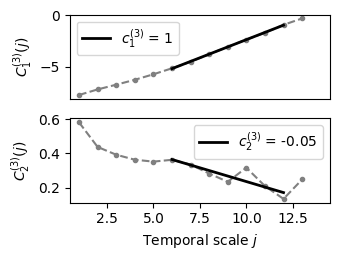

In [6]:
pwt = mfa(wavelet_analysis(mod["modulator"], 'db2').integrate(1).get_leaders(3), [(6, 12)])
pwt.cumulants.plot()

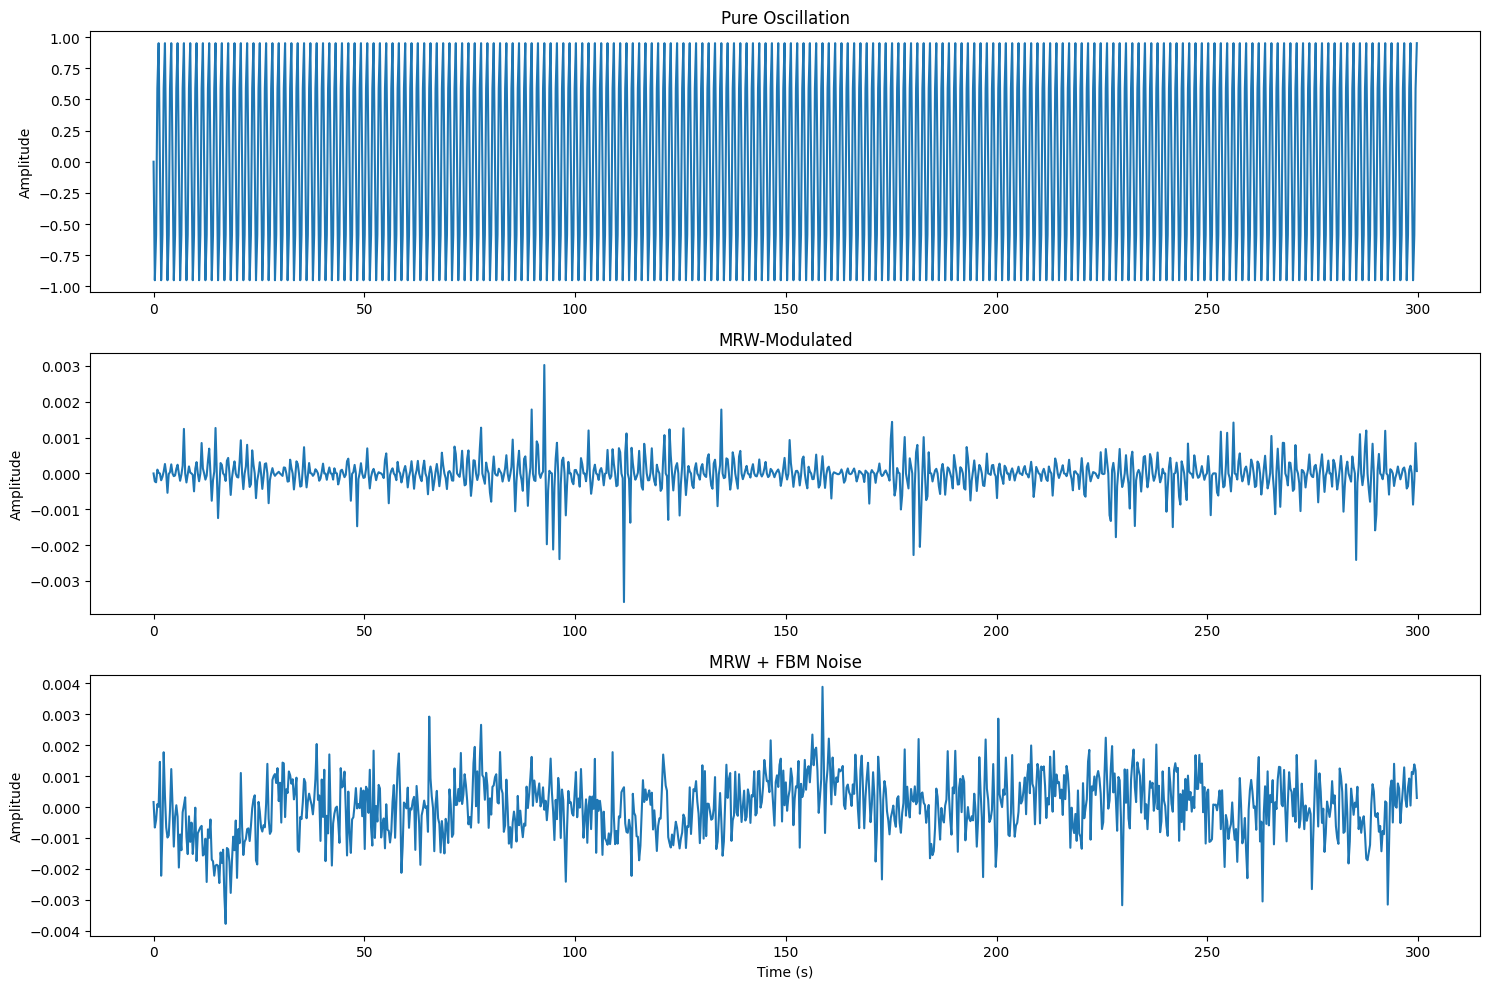

In [7]:
# Prepare data
signal_dicts = [pure, mrw_modulated, mrw_with_fbm]
titles = ["Pure Oscillation", "MRW-Modulated", "MRW + FBM Noise"]

fs = 250  # Sampling frequency
duration = 300
max_points = 1000


n_samples_to_plot = int(fs * duration)
t_full = signal_dicts[0]['time'][:n_samples_to_plot]


# Downsampling step
step = max(1, int(n_samples_to_plot / max_points)) if max_points is not None else 1
t = t_full[::step]

# Plot
plt.figure(figsize=(15, 10))

for i, (signal_dict, title) in enumerate(zip(signal_dicts, titles)):
    y_full = signal_dict['final_signal'][:n_samples_to_plot]
    y = y_full[::step]
    plt.subplot(len(signal_dicts), 1, i + 1)
    plt.plot(t, y)
    plt.title(title)
    plt.ylabel("Amplitude")
    if i == len(signal_dicts) - 1:
        plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()

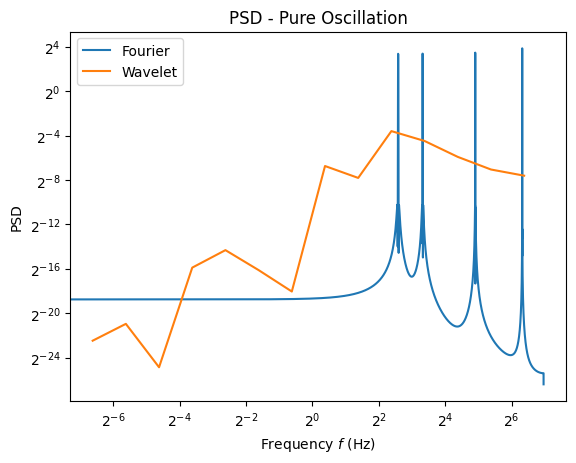

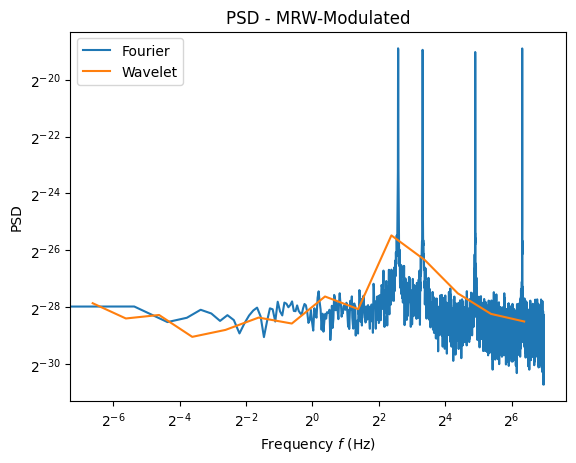

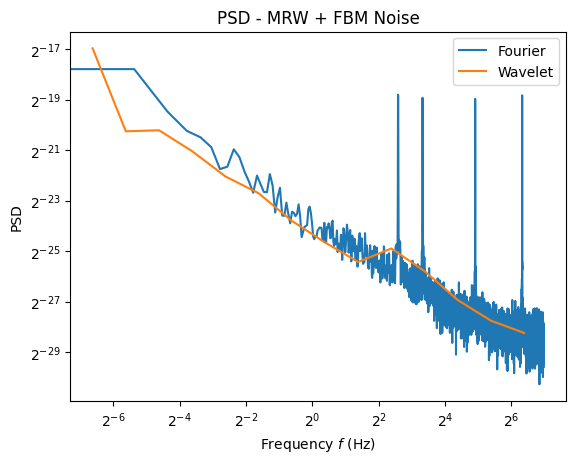

In [8]:
signal_list = [pure["final_signal"], mrw_modulated["final_signal"], mrw_with_fbm["final_signal"]]

for signal, title in zip(signal_list, titles):
    plot_psd(signal, fs=fs)
    plt.title(f"PSD - {title}")
    plt.show()

## 3. Signal decomposition

### Set Parameters:

In [22]:
output_base = "../results/synthetic"
signal_list = [pure["final_signal"], mrw_modulated["final_signal"], mrw_with_fbm["final_signal"]]
signal_names = ["pure", "mrw_modulated", "mrw_with_fbm"]

# PARAMETERS
fs = 250  # Hz
duration = 300.0       # Duration to plot (in seconds)
max_points = 1000      # Optional: downsample to this number of points

n_modes = 5
max_imfs = 8
max_modes = 8

### Run the Decompositions:

In [23]:
methods = [
           # "EMD"
           "VMD"
            #,"VMDtransformer"
            ]


for signal, name in zip(signal_list, signal_names):
    print(f"--- Processing: {name} ---")
    output_dir = os.path.join(output_base, name)
    os.makedirs(output_dir, exist_ok=True)

    # Apply all decompositions
    feats_dict, modes_dict = run_all_decompositions(signal_in=signal,
                                                    methods=methods,
                                                    Fs=fs,
                                                    Nmodes=n_modes,
                                                    MaxEmdIMF=max_imfs,
                                                    MaxVmdModes = max_modes,
                                                    return_modes=True
                                                    #eemd_trials=50,    # Fewer EEMD trials for speed
                                                    #vmd_alpha=500,     # Stronger constraint on bandwidth
                                                    #vmd_tau=1,         # Higher noise tolerance
                                                    #vmd_DC=1,          # DC mode extraction
                                                    #vmd_init=1,        # Initialization strategy
                                                    #vmd_tol=1e-6       # Relaxed convergence tolerance
                                                    )

    for method in feats_dict:
        method_dir = os.path.join(output_dir, method)
        os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)
        os.makedirs(os.path.join(method_dir, "features"), exist_ok=True)
        os.makedirs(os.path.join(method_dir, "figures"), exist_ok=True)


        # Save modes
        np.save(os.path.join(method_dir, "modes", f"{name}_modes.npy"), modes_dict[method])

        # Plot signal + spectrum + modes
        plot_signal_and_modes(
            x=signal,
            sfreq=fs,
            duration = 300,
            max_points = 1000,
            modes=modes_dict[method],
            method=method,
            ch=0,
            output_dir=output_dir,
)

        # Save features
        labels = feats_dict[method]["labels"]
        values = feats_dict[method]["values"]
        df = pd.DataFrame([values], columns=labels)
        df.to_csv(os.path.join(method_dir, "features", f"{name}_features.csv"), index=False)

        print(f"Saved {method} for {name}")



--- Processing: pure ---
Saved VMD for pure
--- Processing: mrw_modulated ---
Saved VMD for mrw_modulated
--- Processing: mrw_with_fbm ---
Saved VMD for mrw_with_fbm


### Summarize the Results:

In [24]:
report_df = summarize_decomposition_results(
    signal_list=signal_list,          # list of signals you processed
    signal_names=signal_names,        # corresponding names
    sfreq=250,                        # your sampling frequency
    base_dir="../results/synthetic",     # change if you're saving somewhere else
    n_modes_to_use=4                  # how many modes to use in partial reconstruction
)


In [25]:
#report_df.to_csv("../results/synthetic/report_synthetic.csv", index=False, mode="a" )
report_df.to_csv("../results/synthetic/report_synthetic.csv", index=False )

In [27]:
report_df[report_df["Method"].isin(["EMD", "VMD"])].head(100)


,Method,Signal,Mode Index,Peak Frequency (Hz),Reconstruction MSE (Full),Reconstruction MSE (First N Modes),Number of Extracted Modes,AM,BM,Entropy,Centroid,Power Spectrum Sum,Skewness,Kurtosis,Hjorth Mobility,Hjorth Complexity
0,EMD,pure,0,80.000000,2.598572e-40,0.001357,9,0.672676,43089.125881,2.846165,77.099625,172.356504,5.947941e-06,-1.752239,1.653813,1.020324
1,EMD,pure,1,30.000000,2.598572e-40,0.001357,9,0.605774,37834.963826,3.821910,30.018115,151.339855,1.683074e-05,-1.487496,0.736922,1.003016
2,EMD,pure,2,10.000000,2.598572e-40,0.001357,9,0.802420,72236.613702,4.172929,9.187075,288.946455,1.055302e-05,-1.006098,0.233950,1.044097
3,EMD,pure,3,6.000000,2.598572e-40,0.001357,9,0.260894,6978.815627,3.379203,6.037482,27.915262,-1.834097e-04,-1.413563,0.150743,1.013700
4,EMD,pure,4,2.000000,2.598572e-40,0.001357,9,0.046288,219.273285,3.240308,2.064081,0.877093,-9.360187e-04,-1.346368,0.050348,1.004038
5,EMD,pure,5,0.054545,2.598572e-40,0.001357,9,0.003436,10.802993,1.110438,0.249169,0.043211,-5.664302e-01,15.577854,0.007312,2.442002
6,EMD,pure,6,0.036364,2.598572e-40,0.001357,9,0.007955,25.650845,2.131379,0.118435,0.102149,-3.985032e-01,5.016086,0.002629,2.034605
7,EMD,pure,7,0.039394,2.598572e-40,0.001357,9,0.006841,13.698914,2.776838,0.090445,0.054761,2.272398e-01,2.824940,0.001567,1.035194
8,EMD,pure,8,0.027273,2.598572e-40,0.001357,9,0.003124,2.568436,2.911849,0.058033,0.010071,1.297730e+00,2.966454,0.000939,0.992553
9,EMD,mrw_modulated,0,80.000000,1.608271e-36,0.289980,9,0.000414,0.021562,3.141481,80.165221,0.000086,-1.826015e-03,1.485566,1.662071,1.056726


| # | Feature               | Code Label  | Description                                                                 |
|---|-----------------------|-------------|-----------------------------------------------------------------------------|
| 1 | Spectral Entropy      | `ent`       | Measures complexity of frequency content — high entropy = noisy modes       |
| 2 | Spectral Power        | `Pfreq`     | Total energy in the mode's spectrum — higher means more meaningful signal   |
| 3 | Peak Frequency (Hz)   | `Ppeak`     | Frequency with maximum power — indicates which rhythm is captured           |
| 4 | Hjorth Mobility       | `Hmob`      | Indicates dominant frequency — higher means faster oscillations             |
| 5 | Hjorth Complexity     | `Hcomp`     | Describes structural irregularity — high = more complex or unstable signal  |


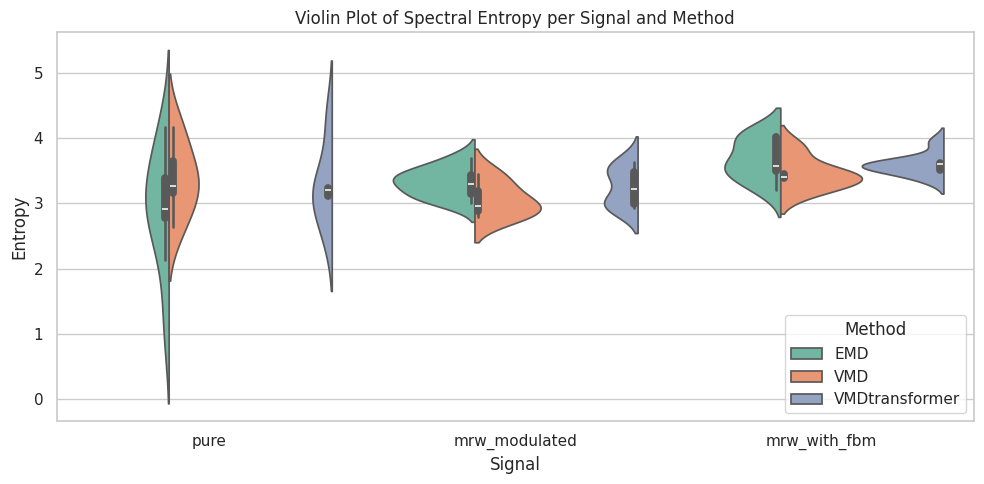

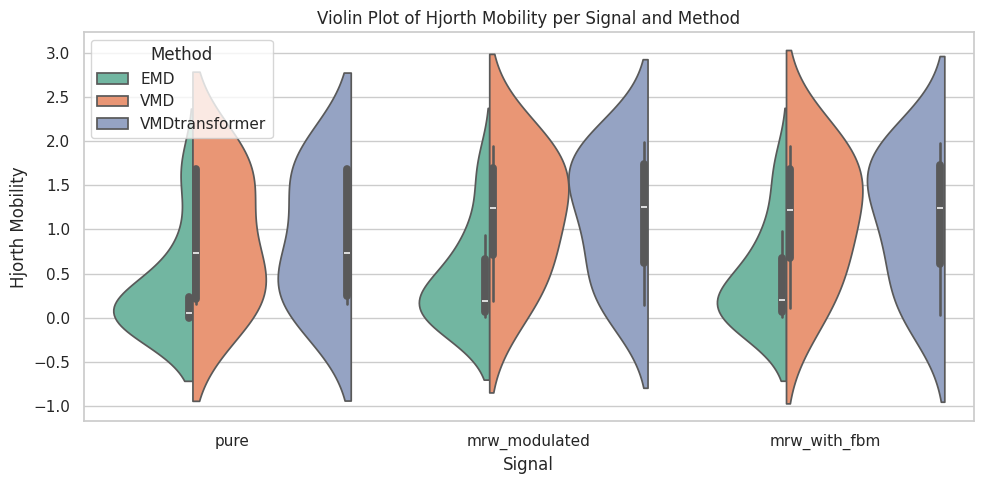

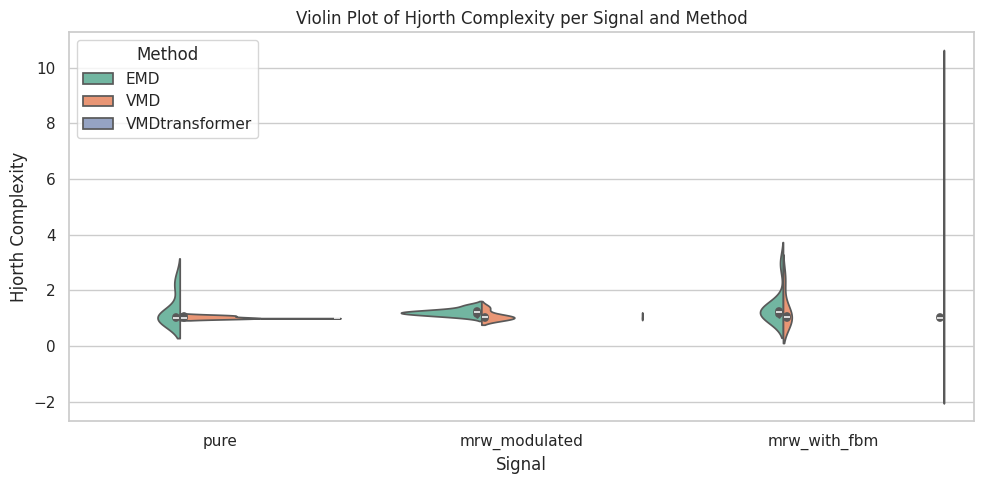

In [65]:
features_to_plot = {
    "Entropy": "Spectral Entropy",
    "Hjorth Mobility": "Hjorth Mobility",
    "Hjorth Complexity": "Hjorth Complexity"
}


# Set plot style
sns.set(style="whitegrid")

# Loop over features
for feat_key, feat_name in features_to_plot.items():
    plt.figure(figsize=(10, 5))
    sns.violinplot(
        data=report_df,
        x="Signal",  # pure / mrw_modulated / mrw_with_fbm
        y=feat_key,
        hue="Method",  # EMD vs VMD
        split=True,
        palette="Set2"
    )
    plt.title(f"Violin Plot of {feat_name} per Signal and Method")
    plt.tight_layout()
    plt.savefig(f"violin_{feat_key}.png", dpi=300)
    plt.show()


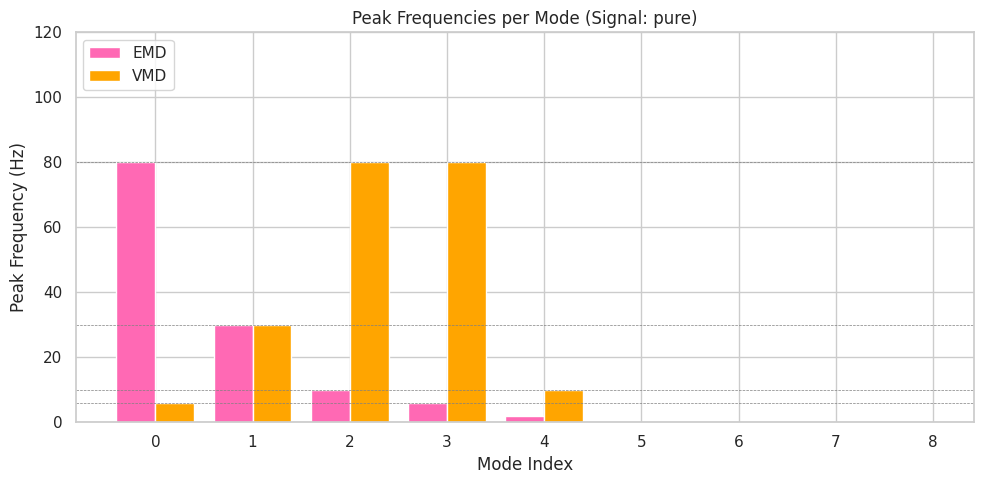

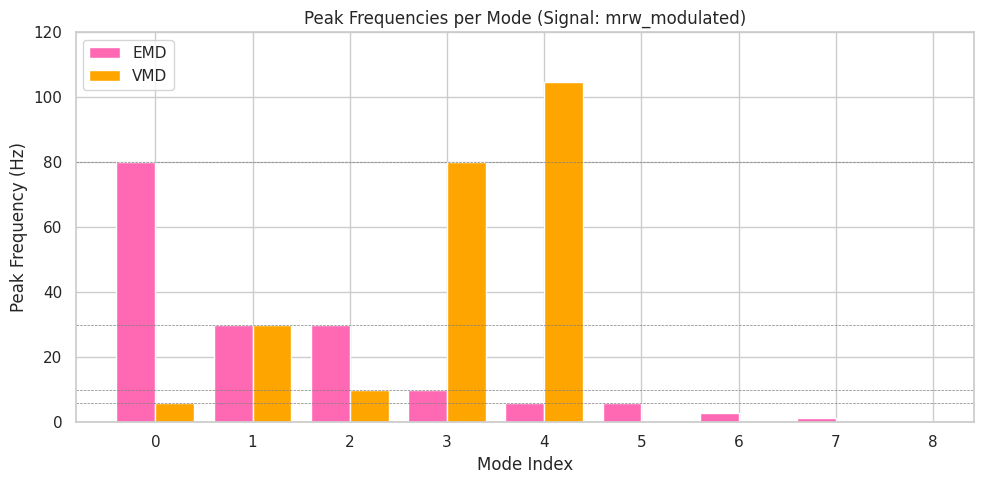

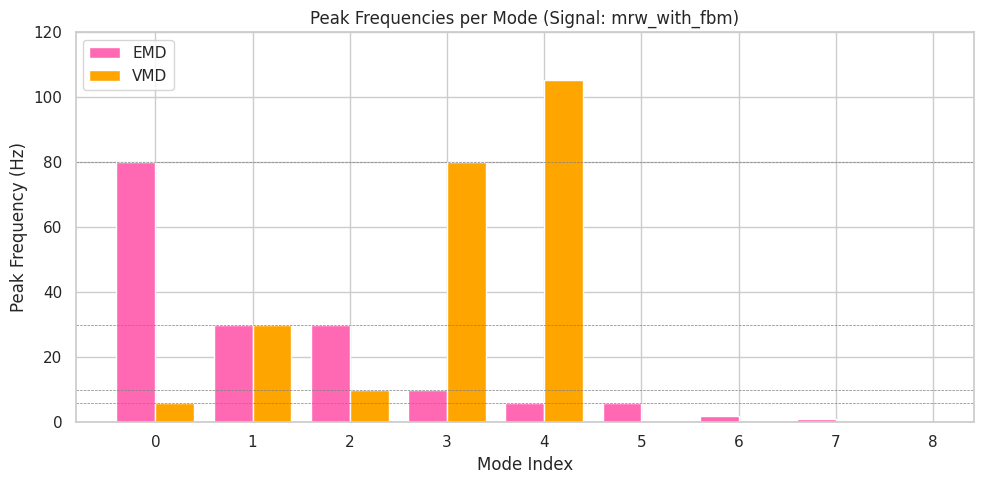

In [73]:
colors = {
    "EMD": "#FF69B4",   # pink
    "VMD": "#FFA500"    # orange
}

signals = report_df["Signal"].unique()
for signal in signals:
    df_sig = report_df[report_df["Signal"] == signal].copy()

    # Align bars: group by mode index and pivot so that EMD and VMD are columns
    pivot_df = df_sig.pivot(index="Mode Index", columns="Method", values="Peak Frequency (Hz)").reset_index()
    pivot_df = pivot_df.sort_values("Mode Index")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    width = 0.4  # width of bars
    x = pivot_df["Mode Index"]

    ax.bar(x - width/2, pivot_df["EMD"], width=width, label="EMD", color=colors["EMD"])
    ax.bar(x + width/2, pivot_df["VMD"], width=width, label="VMD", color=colors["VMD"])

    # Add horizontal lines for target frequencies
    for freq in [6, 10, 30, 80]:
        ax.axhline(freq, linestyle="--", color="gray", linewidth=0.5)

    ax.set_title(f"Peak Frequencies per Mode (Signal: {signal})")
    ax.set_xlabel("Mode Index")
    ax.set_ylabel("Peak Frequency (Hz)")
    ax.set_ylim(0, 120)
    ax.set_xticks(x)
    ax.legend()
    plt.tight_layout()
    plt.show()


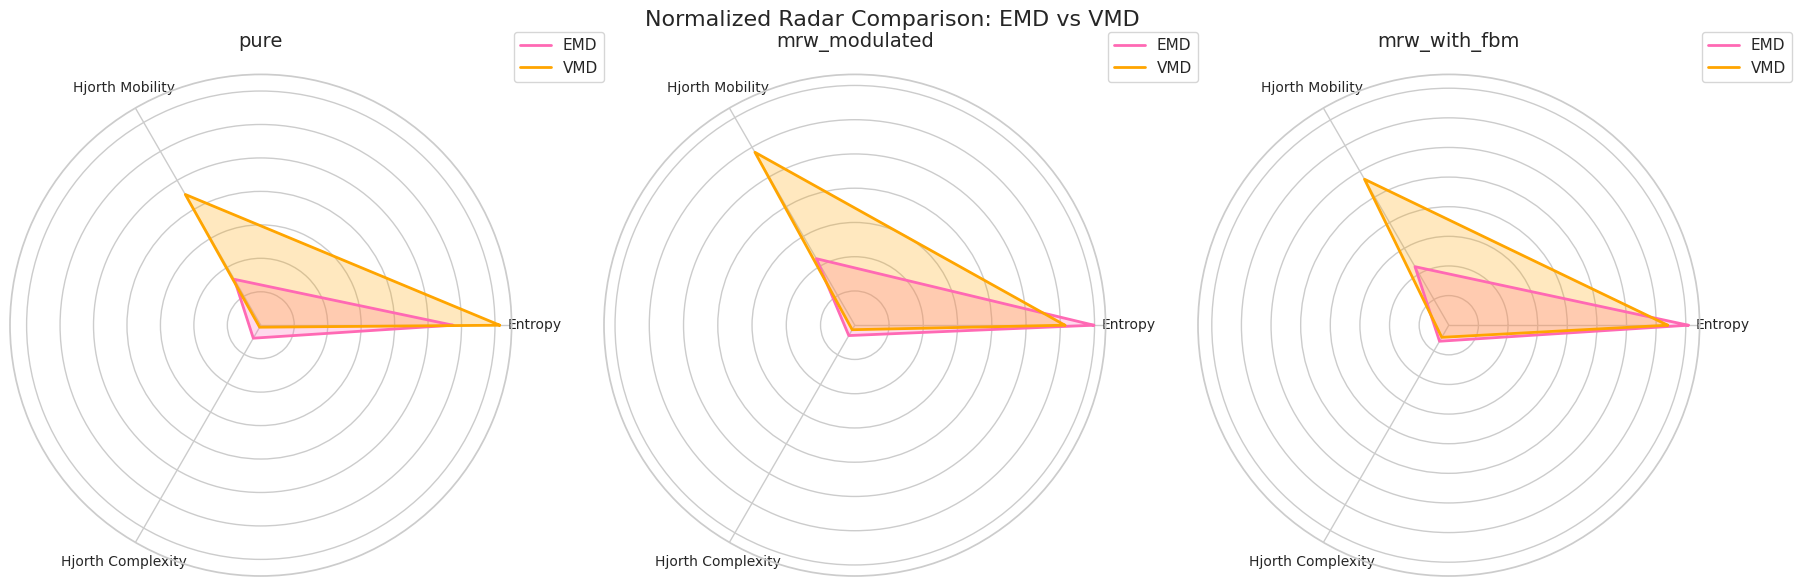

In [69]:
# Select relevant features for radar plot
#radar_features = ["Entropy", "Power Spectrum Sum", "Hjorth Mobility", "Hjorth Complexity"]
radar_features = ["Entropy","Hjorth Mobility", "Hjorth Complexity"]

# Normalize selected features
scaler = MinMaxScaler()
report_df[radar_features] = scaler.fit_transform(report_df[radar_features])

# Plot setup
signals = report_df["Signal"].unique()
angles = np.linspace(0, 2 * np.pi, len(radar_features), endpoint=False).tolist()
angles += angles[:1]

colors = {
    "EMD": "#FF69B4",   # pink
    "VMD": "#FFA500"    # orange
}

fig, axs = plt.subplots(1, len(signals), figsize=(18, 6), subplot_kw=dict(polar=True))

for i, signal in enumerate(signals):
    ax = axs[i]
    for method in ["EMD", "VMD"]:
        subset = report_df[(report_df["Signal"] == signal) & (report_df["Method"] == method)]
        if not subset.empty:
            values = subset[radar_features].mean().tolist()
            values += values[:1]
            ax.plot(angles, values, label=method, color=colors[method], linewidth=2)
            ax.fill(angles, values, color=colors[method], alpha=0.25)
    ax.set_title(signal, size=14, pad=20)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features, fontsize=10)
    ax.set_yticklabels([])
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

plt.suptitle("Normalized Radar Comparison: EMD vs VMD", fontsize=16)
plt.tight_layout()
plt.savefig("radar_horizontal_emd_vmd.png", dpi=300)
plt.show()


### 📊 Scientific Comparison: EMD vs VMD on 3 Signal Types

| **Signal Type**     | **Metric**           | **VMD vs EMD** | **Scientific Interpretation**                                                                 |
|---------------------|----------------------|----------------|----------------------------------------------------------------------------------------------|
| **pure**            | Hjorth Mobility      | ↑ VMD          | VMD captures richer frequency content (more dynamic modes)                                  |
|                     | Hjorth Complexity    | ↓ VMD          | VMD extracts simpler, less convoluted modes                                                  |
|                     | Entropy              | ↑ VMD          | Slightly more spread-out frequency components; may reflect uniformity, not noise            |
|                     | **Conclusion**       | ✅ VMD better   | Better frequency representation and cleaner structure                                        |
| **mrw_modulated**   | Hjorth Mobility      | ↑↑ VMD         | Strong improvement — VMD captures frequency modulation effectively                          |
|                     | Hjorth Complexity    | ↓ VMD          | Simpler decomposition suggests better mode separation                                        |
|                     | Entropy              | ↓ VMD          | Indicates cleaner and more ordered modes                                                     |
|                     | **Conclusion**       | ✅✅ VMD much better | VMD excels on modulated multifractal signals                                                 |
| **mrw_with_fbm**    | Hjorth Mobility      | ↑ VMD          | Even on complex noise-like data, VMD captures diverse frequency features                    |
|                     | Hjorth Complexity    | ↓ VMD          | VMD provides more structured modes                                                           |
|                     | Entropy              | ↓ VMD          | Less randomness → better decomposition quality                                               |
|                     | **Conclusion**       | ✅ VMD better   | VMD handles complex, irregular signals with cleaner outputs                                 |



## 3. Apply the MFA:

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# from PyEMD import EMD

# # Time axis
# fs = 1000
# t = np.linspace(0, 1, fs)

# # True components
# c1 = np.sin(2 * np.pi * 5 * t)
# c2 = np.sin(2 * np.pi * 20 * t)
# c3 = np.sin(2 * np.pi * 60 * t)
# signal = c1 + c2 + c3

# # EMD decomposition
# emd = EMD()
# imfs = emd.emd(signal, t)

# # Plot
# fig, axes = plt.subplots(5, 1, figsize=(12, 8), sharex=True)
# fig.suptitle("Empirical Mode Decomposition (EMD)", fontsize=14)

# axes[0].plot(t, signal, color='black')
# axes[0].set_ylabel("Original Signal")

# axes[1].plot(t, c1, label='5 Hz', linestyle='--')
# axes[1].plot(t, c2, label='20 Hz', linestyle='-.')
# axes[1].plot(t, c3, label='60 Hz', linestyle=':')
# axes[1].legend()
# axes[1].set_ylabel("True Components")

# for i in range(min(3, imfs.shape[0])):
#     axes[i+2].plot(t, imfs[i])
#     axes[i+2].set_ylabel(f"IMF {i+1}")

# axes[-1].set_xlabel("Time (s)")
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()
